In [116]:
from data_creation import get_trajectories
%load_ext autoreload
%autoreload 2

sol = get_trajectories()

x,y,vx,vy,t = sol

print((x.shape))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(3, 100000)


In [117]:
import numpy as np


# Applied sigmoid but does not seem to do much
# We can first try without sigmoid


# custom function
def sigmoid(x):
  return 1 / (1 + np.exp(-x))


# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)

# # test
x_sig = sigmoid(x)  
y_sig = sigmoid(y)
vx_sig = sigmoid(vx)
vy_sig = sigmoid(vy)




(100000, 12)
(100000, 12)


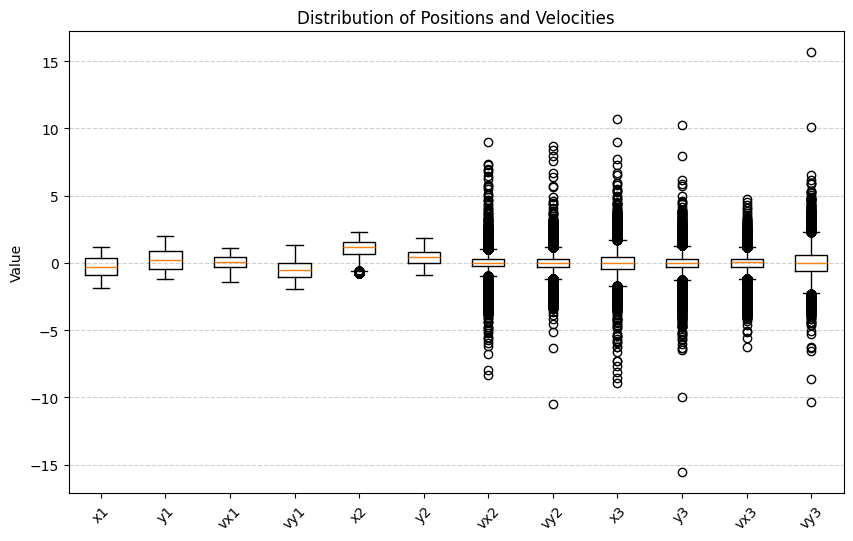

In [118]:
import numpy as np
import pandas as pd

data = np.vstack((x, y, vx, vy)).T
data2 = np.vstack((x_sig, y_sig, vx_sig, vy_sig)).T

def remove_outliers(data):
    # Compute quartiles along each column (dimension)
    Q1 = np.percentile(data, 25, axis=0)
    Q3 = np.percentile(data, 75, axis=0)
    IQR = Q3 - Q1
    
    # Define the upper and lower limits for each dimension
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    
    # Use np.clip to cap values per dimension
    capped_data = np.clip(data, lower_limit, upper_limit)
    
    return capped_data
print(data2.shape)
data3 = remove_outliers(data2)
print(data3.shape)

from data_creation import plot_boxplots
plot_boxplots(data)

In [119]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, RobustScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense

(100000, 12)


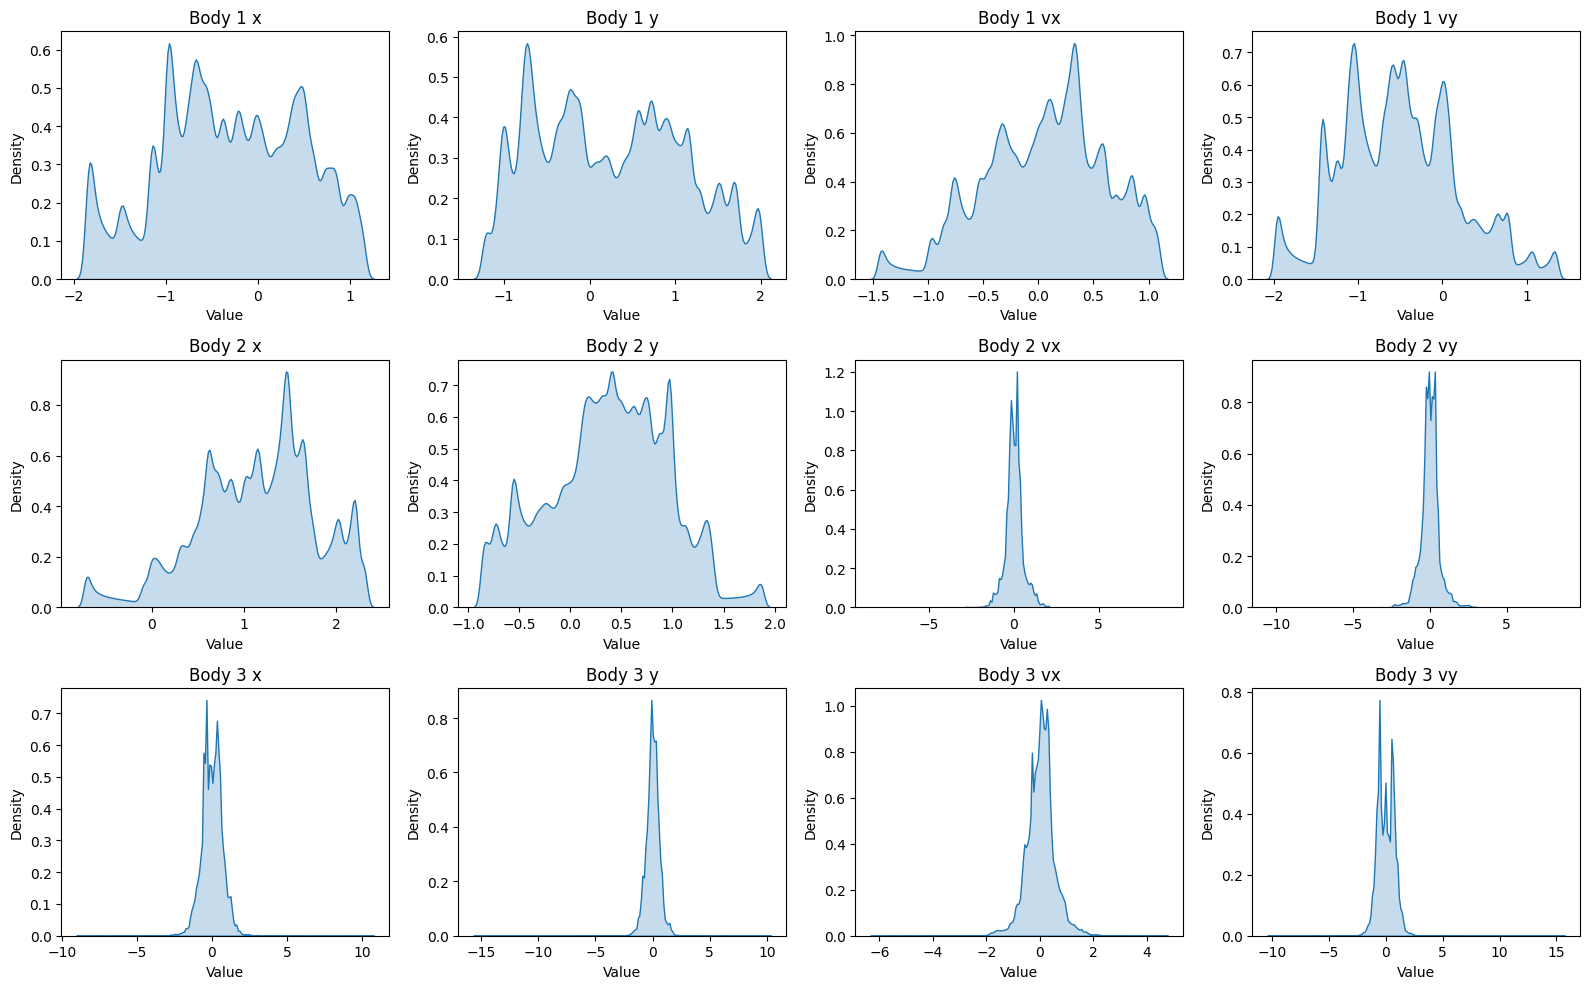

In [120]:
from data_creation import transform_data
sliding_window = 10
forecast_horizon = 10
X_train, y_train, X_test, y_test, scaler = transform_data(data, window_size=sliding_window, test_size=0.2, forecast_horizon=forecast_horizon)



import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Suppose your array is called `data`
# shape = (84999, 12)
new_data = X_train.reshape(-1, X_train.shape[-1])  # shape = (849990, 12)
num_features = data.shape[1]
fig, axes = plt.subplots(3, 4, figsize=(16, 10))  # 3 rows × 4 cols for 12 features
axes = axes.flatten()

bodies = ["Body 1", "Body 2", "Body 3"]
components = ["x", "y", "vx", "vy"]
feature_names = [f"{body} {comp}" for body in bodies for comp in components]

for i in range(num_features):
    sns.kdeplot(data[:, i], ax=axes[i], fill=True, bw_adjust=0.5)
    axes[i].set_title(feature_names[i])
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Density")

plt.tight_layout()
plt.show()

# # Convert to DataFrame
# df = pd.DataFrame(X_test[:,-1,:], columns=[f"col_{i}" for i in range(X_test[:,-1,:].shape[1])])

# # Save to Excel
# df.to_excel("output.xlsx", index=False)

# df = pd.DataFrame(y_test, columns=[f"col_{i}" for i in range(y_test.shape[1])])

# # Save to Excel
# df.to_excel("output2.xlsx", index=False)



In [121]:
from LSTMCell import LSTM
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

input_window_size = 12
hidden_size = 32
num_layers = 2

model = LSTM(input_window_size, hidden_size, num_layers)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
num_epochs = 20
losses, val_loss = model.training_loop_cv(
    num_epochs = num_epochs, 
    criterion = criterion,
    optimizer = optimizer,
    trainX = X_train,
    trainY = y_train
)



Fold 1
Epoch [1/20], Train Loss: 0.2755, Val Loss: 0.2228, R2: -87.8152
Epoch [2/20], Train Loss: 0.1159, Val Loss: 0.0207, R2: -2.1460
Epoch [3/20], Train Loss: 0.0216, Val Loss: 0.0234, R2: -0.7653
Epoch [4/20], Train Loss: 0.0183, Val Loss: 0.0246, R2: -0.8025
Epoch [5/20], Train Loss: 0.0180, Val Loss: 0.0248, R2: -0.8224
Early stopping triggered
Fold 2
Epoch [1/20], Train Loss: 0.0167, Val Loss: 0.0254, R2: -1.0400
Epoch [2/20], Train Loss: 0.0180, Val Loss: 0.0250, R2: -0.9877
Epoch [3/20], Train Loss: 0.0180, Val Loss: 0.0250, R2: -0.9751
Epoch [4/20], Train Loss: 0.0180, Val Loss: 0.0250, R2: -0.9673
Epoch [5/20], Train Loss: 0.0180, Val Loss: 0.0250, R2: -0.9607
Epoch [6/20], Train Loss: 0.0179, Val Loss: 0.0250, R2: -0.9538
Epoch [7/20], Train Loss: 0.0179, Val Loss: 0.0249, R2: -0.9458
Epoch [8/20], Train Loss: 0.0178, Val Loss: 0.0249, R2: -0.9360
Epoch [9/20], Train Loss: 0.0177, Val Loss: 0.0248, R2: -0.9240
Epoch [10/20], Train Loss: 0.0176, Val Loss: 0.0247, R2: -0.9095

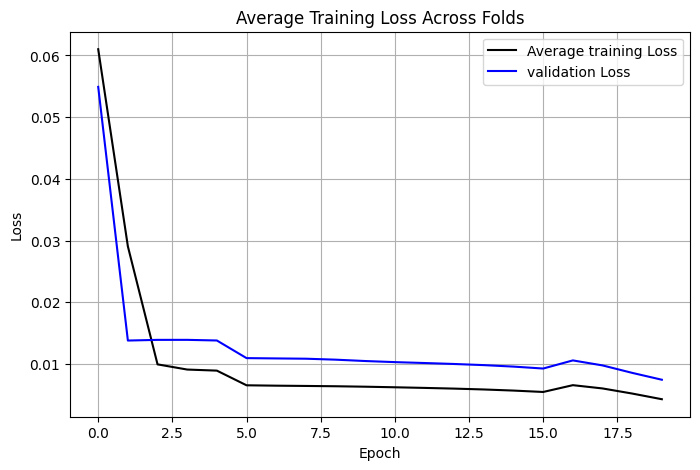

In [122]:

max_len = num_epochs

# ensure sub arrays are of the same length by padding with -1
losses_array = np.array([
    lst + [-1] * (max_len - len(lst)) if len(lst) < max_len else lst[:max_len]
    for lst in losses
])
# compute average ignoring -1 values
avg_loss = np.mean(losses_array, axis=0, where=(losses_array != -1))

# ensure sub arrays are of the same length by padding with -1
losses_array_val = np.array([
    lst + [-1] * (max_len - len(lst)) if len(lst) < max_len else lst[:max_len]
    for lst in val_loss
])
# compute average ignoring -1 values
avg_val_loss = np.mean(losses_array_val, axis=0, where=(losses_array_val != -1))

plt.figure(figsize=(8, 5))
plt.plot(avg_loss, color='black', label='Average training Loss')
plt.plot(avg_val_loss, color='blue', label='validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Training Loss Across Folds')
plt.grid(True)
plt.legend()
plt.show()

Generate time series from 1 input and plot both in one plot

### Save model

In [123]:
import time

timestamp = time.strftime("%Y%m%d-%H%M%S")
filename = f"models/model_{timestamp}.pt"

torch.save(model, filename)
print(f"Model saved to {filename}")

Model saved to models/model_20251024-122136.pt


### Load model

In [124]:
import os
model_path = ""

if os.path.exists(model_path):
    print("Loading saved model...")
    model = torch.load(model_path)

In [125]:
from sklearn.metrics import r2_score

losses = []
r2_scores = []
test_preds = []
for i, x in enumerate(X_test):
    with torch.no_grad():
        
        y_pred = model.forward(torch.from_numpy(x).float().unsqueeze(0))
        test_preds.append(y_pred.numpy().flatten())
        # Compute MSE
        y_val = torch.tensor(y_test[i], dtype=torch.float32)
        mse_loss = criterion(y_pred, y_val.unsqueeze(0)).item()
        losses.append(mse_loss)

        
        # Compute R2
        r2 = r2_score(y_val.numpy(), y_pred.detach().numpy().flatten())
        r2_scores.append(r2)
        # print(f"MSE: {mse_loss}, R2: {r2}")

print(f"Average MSE on test set: {np.mean(losses)}")
print(f"Average R2 on test set: {np.mean(r2_scores)}")



Average MSE on test set: 0.0022422077478729398
Average R2 on test set: 0.9394809057990845


(19996, 10, 12)
(19, 12)
0.004005855415016413
0.004003345500677824
0.004000838380306959
0.003998328000307083
0.003995819017291069
0.003993310499936342
0.003990799188613892
0.003988288808614016
0.003985780756920576
0.0039832694455981255
0.004096435382962227
0.0042913225479424
0.004542865324765444
0.004837218206375837
0.005166655406355858
0.005526835564523935
0.005914625246077776
0.006325798109173775
0.0067520164884626865
0.007177502382546663
0.007179005071520805
0.00719106150791049
0.007218692451715469
0.007266118656843901
0.007336843758821487
0.007433833088725805
0.007559603545814753
0.007716212421655655
0.007905062288045883
0.008126373402774334
0.008357456885278225
0.008583532646298409
0.008794992230832577
0.008985941298305988
0.009153258055448532
0.0092959925532341
0.009415080770850182
0.009513179771602154
0.009594757109880447
0.00966628361493349
0.009757242165505886
0.009867421351373196
0.00999509822577238
0.010137279517948627
0.010289954952895641
0.010448425076901913
0.010607607662

c:\Users\Wout Teillers\Documents\AI\Master\Year1\1a\Advanced_machine_learning\Code\venv\lib\site-packages\torch\nn\modules\loss.py:616: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([1, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0.018517984077334404
0.018690994009375572
0.0188654363155365
0.01904098130762577
0.019217463210225105
0.01939490996301174
0.019573519006371498
0.019753647968173027
0.01993568241596222
0.02012002095580101
0.020307021215558052
0.020496908575296402
0.020689761266112328
0.020885519683361053
0.021084023639559746
0.02128499560058117
0.021488159894943237
0.021693259477615356
0.021900082007050514
0.022108562290668488
0.022318700328469276
0.02253061532974243
0.022744497284293175
0.022960571572184563
0.023179078474640846
0.023400207981467247
0.02362407185137272
0.023850686848163605
0.024080028757452965
0.024311969056725502
0.024546340107917786
0.024782950058579445
0.02502164989709854
0.025262294337153435
0.025504805147647858
0.025749189779162407
0.02599547989666462
0.026243766769766808
0.026494160294532776
0.02674674801528454
0.027001602575182915
0.027258774265646935
0.027518248185515404
0.02777993120253086
0.02804374508559704
0.028309553861618042
0.028577199205756187
0.028846554458141327
0.0291

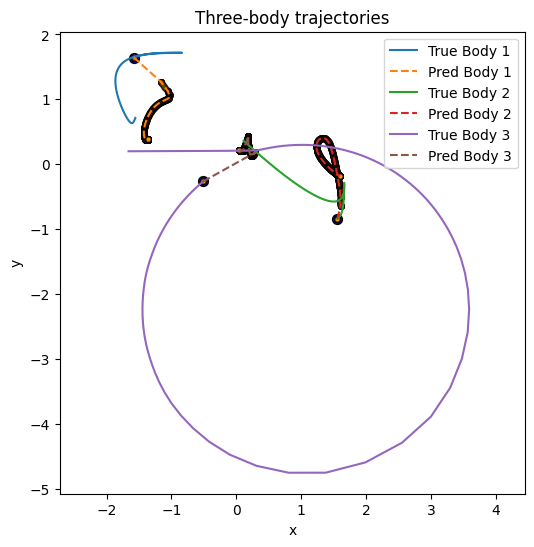

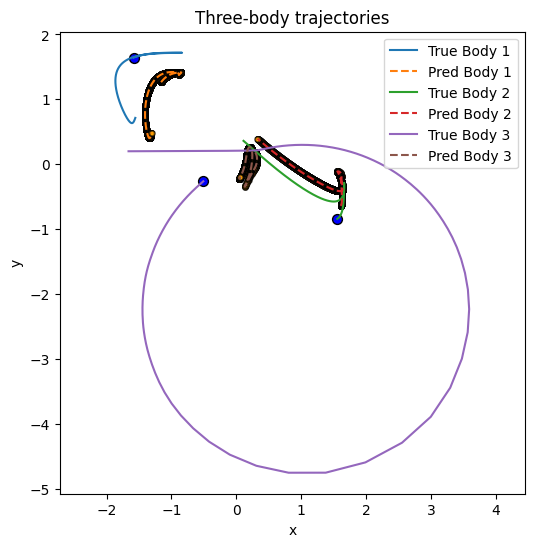

In [126]:
from data_creation import plot_trajectories
steps = 5000

print(X_test.shape)
generated = X_test[:19]  # TODO make this dynamical based of sliding window size
generated = generated[:, -1, :]
print(generated.shape)

output = model.generate_timeseries(steps=steps, generated=generated, Y_test=y_test[20:], criterion=criterion, sliding_window_size=sliding_window)

# remove middle dimension
X_test_selected = X_test[:, 0, :]

plot_trajectories(scaler.inverse_transform(y_test[0:steps]), scaler.inverse_transform(output))
plot_trajectories(scaler.inverse_transform(y_test[0:steps]), scaler.inverse_transform(test_preds[0:steps]))

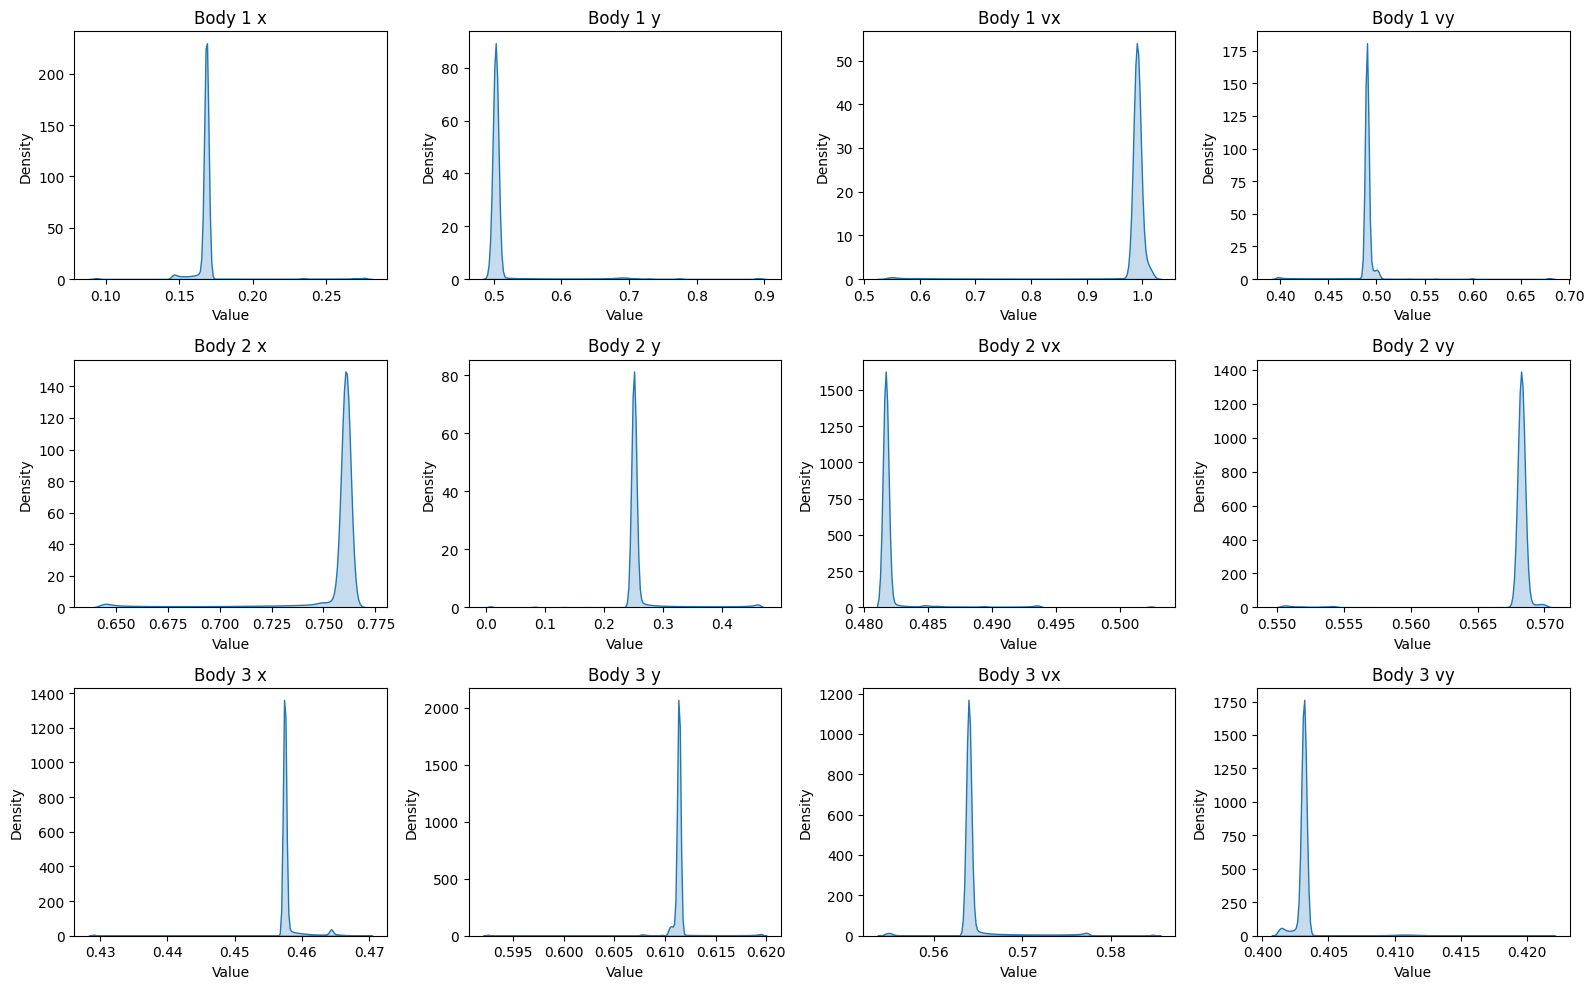

In [127]:
bodies = ["Body 1", "Body 2", "Body 3"]
components = ["x", "y", "vx", "vy"]
feature_names = [f"{body} {comp}" for body in bodies for comp in components]

num_features = output.shape[1]
fig, axes = plt.subplots(3, 4, figsize=(16, 10))  # 3 rows × 4 cols for 12 features
axes = axes.flatten()

for i in range(num_features):
    sns.kdeplot(output[:, i], ax=axes[i], fill=True, bw_adjust=0.5)
    axes[i].set_title(feature_names[i])
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Density")

plt.tight_layout()
plt.show()

### Grid search

In [128]:
from itertools import product
import torch
import os
import pandas as pd

# define the grid search parameters
param_grid = {'num_layers': [2, 4, 8],
              'optimizer': ['Adam'], #'SGD', 'RMSprop', for now only Adam
              'learning_rate': [0.01, 0.001, 0.0001],
              #'window_size': [10, 50, 100],
              'hidden_size': [32, 64, 128],
              #'forecast_horizon': [1, 10, 100]
              }


# generate combinations
keys = list(param_grid.keys())
combinations = [dict(zip(keys, values)) for values in product(*param_grid.values())]
print(f"Total combinations to try: {len(combinations)}")
print(f"If training takes half an hour per combination, this will take {len(combinations)*0.5:.2f} hours, which is {len(combinations)*0.5/24:.2f} days.")

results_path = "grid_search_results.csv"
if os.path.exists(results_path):
    results_df = pd.read_csv(results_path)
else:
    results_df = pd.DataFrame(columns=keys + ["val_loss"])

best_val_loss = results_df["val_loss"].min() if not results_df.empty else float('inf')
best_params = None
best_model_state = None

for combo in combinations:
    mask = (results_df[list(combo.keys())] == pd.Series(combo)).all(axis=1)
    if mask.any():
        print(f"Skipping already completed combo: {combo}")
        continue

    print(f"Training with combo: {combo}")


    model = LSTM(input_window_size=12,
                 hidden_size=combo['hidden_size'],
                 num_layers=combo['num_layers'])
    
    if combo['optimizer'] == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=combo['learning_rate'])
    elif combo['optimizer'] == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=combo['learning_rate'], weight_decay=1e-4)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=combo['learning_rate'])
    
    criterion = nn.MSELoss()

    num_epochs = 20
    losses, val_loss = model.training_loop_cv(
        num_epochs=num_epochs,
        criterion=criterion,
        optimizer=optimizer,
        trainX=X_train,
        trainY=y_train
    )

    final_val_loss = np.average(val_loss[-1])

    # save result immediately
    results_df.loc[len(results_df)] = {**combo, "val_loss": final_val_loss}
    results_df.to_csv(results_path, index=False)

    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_params = combo
        best_model_state = model.state_dict()

print(f"Best combo: {best_params} with val loss: {best_val_loss:.4f}")
torch.save(best_model_state, "best_lstm_model.pt")
print("Best model saved to best_lstm_model.pt")

Total combinations to try: 27
If training takes half an hour per combination, this will take 13.50 hours, which is 0.56 days.
Skipping already completed combo: {'num_layers': 2, 'optimizer': 'Adam', 'learning_rate': 0.01, 'hidden_size': 32}
Skipping already completed combo: {'num_layers': 2, 'optimizer': 'Adam', 'learning_rate': 0.01, 'hidden_size': 64}
Skipping already completed combo: {'num_layers': 2, 'optimizer': 'Adam', 'learning_rate': 0.01, 'hidden_size': 128}
Skipping already completed combo: {'num_layers': 2, 'optimizer': 'Adam', 'learning_rate': 0.001, 'hidden_size': 32}
Skipping already completed combo: {'num_layers': 2, 'optimizer': 'Adam', 'learning_rate': 0.001, 'hidden_size': 64}
Training with combo: {'num_layers': 2, 'optimizer': 'Adam', 'learning_rate': 0.001, 'hidden_size': 128}
Fold 1
Epoch [1/20], Train Loss: 0.0276, Val Loss: 0.0479, R2: -2.1775
Epoch [2/20], Train Loss: 0.0156, Val Loss: 0.0405, R2: -1.5144
Epoch [3/20], Train Loss: 0.0180, Val Loss: 0.0336, R2: -

KeyboardInterrupt: 